# CHART Analysis Tutorial

This notebook will guide you through several analysis steps using data collected by a CHART telescope. You can run the notebook as-is using the example data, or you can use your own data -- you will just need to change a few things along the way (we'll be sure to tell you what to change where).

The tutorial outline is below for reference, but be sure to run **all** cells along the way, even if you are only interested in a specific step.

### Tutorial Outline
0. Preliminaries<br>
1. Reading in data<br>
2. Basic conversions and corrections<br> 
   a. Bandpass and automatic gain correction<br>
   b. Doppler shift<br>
   c. Average overlapping data<br>
3. Comparing to survey and calibrating<br>
   a. Sky coordinates and reference frames<br>
   b. LAB Survey data<br>
   c. Calibrate against a model<br>
4. Making a Rotation Curve<br>
   a. Tangent point method<br>
   b. Finding highest velocity clouds<br>
   c. Plotting rotation curve

## 0. Preliminaries

First, we need to import the python packages used for the analysis. If you are using the provided Raspberry Pi image, these should already be installed. If you are not, you will need to install them with a package manager such as pip or conda, and will need to install the CHART package using the instructions on the github. Run the cell below to import the packages. You do not need to change anything in this cell.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import chart
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord, AltAz, ICRS
from astropy.time import Time
import pandas as pd
from ipywidgets import interact, FloatSlider, Dropdown
import scipy.constants as const

The cell below defines a few constants and useful functions. These constants and functions will be used in later steps of the code. Run the cell below. You do not need to change anything in this cell.

In [2]:
# A couple constants and useful functions for later.
f_e = 1.420405751768 * u.GHz  # Rest frequency of HI hyperfine transition
speed_of_light = const.speed_of_light * (u.meter / u.second)

def freq2vel(freq, rest=f_e):
    """
    Calculates velocity from measured frequency via doppler shift.
    
    :param freq: array of frequency quantities (including units)
    :param rest (optional): Rest frequency, defaults to 1.42 GHz
    :returns vel: velocity inferred by doppler shift
    """
    return (rest - freq) * speed_of_light / freq

def get_gal_coords(longitude, latitude, elevation, time, 
                   altitude, azimuth, return_vadj=False):
    """
    Determines galactic coordinates of an observation and
    optionally also calculates the velocity adjustment
    for the Local Standard of Rest.  
    
    :param latitude: latitude in degrees
    :param longitude: longitude in degrees
    :param elevation: elevation in meters
    :param time: observation time in UTC format string
    :param altitude: altitude in degrees
    :param azimuth: azimuth in degrees
    :param return_vadj (optional): If set to True, returns the 
                             velocity adjustment for the
                             Local Standard of Rest in addition
                             to the galactic coordinates (l, b).
                             If False (default) only returns (l, b).
    """
    
    loc = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg, height=elevation*u.m)
    altaz = AltAz(obstime=Time(time), location=loc, alt=altitude*u.deg, az=azimuth*u.deg)
    skycoord = SkyCoord(altaz.transform_to(ICRS))
    if not return_vadj:
        return skycoord.galactic
    loc = loc.get_itrs(obstime=Time(time)) #To ITRS frame, makes Earth stationary with Sun 
    frequency = SpectralCoord(f_e, observer=loc, target=skycoord) #Shift expected from just local motion
    f_shifted = frequency.with_observer_stationary_relative_to('lsrk') #correct for kinematic local standard of rest
    f_shifted = f_shifted.to(u.GHz)
    v = -freq2vel(f_shifted, f_e)
    v_adj = v.to(u.km/u.second)
    return skycoord.galactic, v_adj

def find_array_with_number(freqs, pointing, number):
    for k_index, k in enumerate(freqs[pointing]):
        if np.any((k[:-1] >= number) & (number >= k[1:])):
            return k_index, k
    return None, None

def average_overlapping(x1, y1, x2, y2, x3, y3):
    """
    Averages the y values where the x values are shared between 
    arrays and keeps y values for x values that are not shared.
    Assumes an x value is shared by at most two arrays.
    
    :param x1: First x array
    :param y1: First y array
    :param x2: Second x array
    :param y2: Second y array
    :param x3: Third x array
    :param y3: Third y array
    :return: Tuple of combined x values and averaged/kept y values
    """
    # Find the unique x values in both arrays
    unique_x = np.union1d(x1, x2)
    unique_x = np.union1d(unique_x, x3)
    
    # Create an array to store the averaged/kept y values
    avg_y = np.zeros(unique_x.shape)
    
    # Iterate over the unique x values
    for i in range(len(unique_x)):
        # Find the indices of the current x value in the two x arrays
        ind1 = np.where(x1 == unique_x[i])[0]
        ind2 = np.where(x2 == unique_x[i])[0]
        ind3 = np.where(x3 == unique_x[i])[0]
        
        # If the current x value is arrays 1 and 2
        if len(ind1) > 0 and len(ind2) > 0:
            # Compute the average of the two corresponding y values
            avg_y[i] = (y1[ind1[0]] + y2[ind2[0]]) / 2
        # If the current x value is only in the first array
        elif len(ind1) > 0:
            # Keep the corresponding y value from the first array
            avg_y[i] = y1[ind1[0]]
        # If the current x value is in arrays 2 and 3
        elif len(ind2) > 0 and len(ind3) > 0:
            # Compute the average of the two corresponding y values
            avg_y[i] = (y2[ind2[0]] + y3[ind3[0]]) / 2
        # If the current x value is only in the second array
        elif len(ind2) > 0:
            # Keep the corresponding y value from the second array
            avg_y[i] = y2[ind2[0]]
        # If the current x value is only in the third array
        elif len(ind3) > 0:
            # Keep the corresponding y value from the second array
            avg_y[i] = y3[ind3[0]]
    
    return unique_x, avg_y


def interactive_plot(x):
    """
    Creates a plot that can be modified with sliders.
    
    param x: x values of overlapping CHART data
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    a = b = c = [1] * 4

    lines = [ax.plot(x, (a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2)))))))[0] for i in range(4)]
    lines.append(ax.plot(x, sum([a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2))))) for i in range(4)]))[0])

    sliders = [FloatSlider(min=-100, max=100, step=1, value=1) for _ in range(12)]
    colors = ['black']*4 + ['red']
    color_dropdowns = [Dropdown(options=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'], value=colors[i]) for i in range(5)]
    
    def update(a1=1, b1=1, c1=1, a2=1, b2=1, c2=1, a3=1, b3=1, c3=1, a4=1, b4=1, c4=1,
               color1='black', color2='black', color3='black', color4='black', color5='red'):
        a = [a1,a2,a3,a4]
        b = [b1,b2,b3,b4]
        c = [c1,c2,c3,c4]
        for i in range(4):
            lines[i].set_ydata((a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2)))))))
        lines[4].set_ydata(sum([a[i]*(np.exp(-(((x-b[i])**2) / (2*(c[i]**2))))) for i in range(4)]))
        for i in range(5):
            lines[i].set_color(colors[i])
        fig.canvas.draw_idle()

    interact(update, 
             a1=sliders[0], b1=sliders[1], c1=sliders[2],
             a2=sliders[3], b2=sliders[4], c2=sliders[5],
             a3=sliders[6], b3=sliders[7], c3=sliders[8],
             a4=sliders[9], b4=sliders[10], c4=sliders[11],
             color1=color_dropdowns[0], color2=color_dropdowns[1],
             color3=color_dropdowns[2], color4=color_dropdowns[3],
             color5=color_dropdowns[4])
     
    return ax

## 1. Reading in data

The CHART data taking package produces two types of files -- a data file, and a metadata file. The data file will have a `.dat` extension, and the metadata has a `.metadata.npz`. Each observation should have an associated data and metadata file. The metadata has information about the data, such as the frequencies and times of the observation, and the data contains the observation. The CHART package generates a folder that contains all the data and metadata files for a single observation. You will need to run this notebook on the machine that contains your data. This could be the machine you used to take your data, or a machine that you have transferred your data onto. If you would just like to learn about the analysis steps, you can use the test data provided for this notebook.

We will use two *variables* to point the program to your data. Once we set the variables, they can be re-used throughout the notebook.
1. The `data_dir` variable indicates the larger file tree where your observations are located. We use quotes around the value of the variable to tell python that the variable is a *string*. Here, ours is called `'test_data/'`. 
2. The `paths` variable is a list of your observations within the `data_dir` directory. We use square brackets, `[ ]` to indicate a list, and each item in the list is wrapped in quotes to show they are strings. There may be more or less than three paths depending on how many observations you took. You can simply add more to the list if you have more than three.

If you would like to use the test data, you do not need to change anything in this cell. However, if you would like to use your own data, you just need to change the variables listed above.

Once you have pointed to your data, run the cell below. It will print out some information about each observation from your metadata, such as the data, time, and center frequency, as well as a few other parameters.

In [3]:
### Change these variables to use your own data ###
data_dir = 'test_data/'
paths = ['abeardsley_Winona-HS-Park_2022.10.08_1_6:12_pm',
         'abeardsley_Winona-HS-Park_2022.10.8_2_6:25_pm',
         'abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm']

ntrials = len(paths)
stack_figsize = (6, ntrials * 2.5)
single_figsize = (6, 4)

data = []
mdata = []
bps = []  # bandpasses

for i in range(ntrials):
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    # Rough estimate for bandpass
    nchans = m[0]['vector_length']
    levels = np.median(d[:, :, nchans // 4:(-nchans // 4)], axis=(1, 2))
    rescaled = d / levels.reshape(-1, 1, 1)
    bp = np.median(rescaled, axis=(0, 1))
    bps.append(bp)

for i in range(ntrials):
    print('Trial: '+str(i))
    chart.analysis.print_meta(mdata[i][0])

Trial: 0
date :	 2022-10-08
start_time :	 1665271803.061299
end_time :	 1665271814.9317102
samp_rate :	 2000000.0
frequency :	 1410000000.0
vector_length :	 1024
int_length :	 976
data_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-03.562153.dat
metadata_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-03.562153.metadata.npz
Number of time integrations:	20
dtype :	 [<class 'numpy.float32'>]
Trial: 1
date :	 2022-10-08
start_time :	 1665271803.061299
end_time :	 1665271826.6499507
samp_rate :	 2000000.0
frequency :	 1411000000.0
vector_length :	 1024
int_length :	 976
data_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-15.541138.dat
metadata_file :	 /home/pi/data/abeardsley_Winona-HS-Park_2022.10.8_3_6:30_pm/2022-10-08_18-30-15.541138.metadata.npz
Number of time integrations:	20
dtype :	 [<class 'numpy.float32'>]
Trial: 2
date :	 2022-10-08
start_time :	 1665271803.061299
end_

The next three cells plot the raw CHART data for each observation. The x-axis represents the recorded frequencies in Gigahertz (GHz) and the y-axis shows the signal strength in decibels (dB) for each frequency. Each color represents a different 'tuning' in the data. The software defined radio used for taking data has a limited frequency range, and can only digitize 2 MHz worth of data at a time. In order to scan a larger frequency range, the SDR must do it in steps, or 'tunings'. It will be difficult to see anything in the data in these plots, as a few further calibration steps are needed. The vertical dashed black line indicates the rest frequency of neutral hydrogen. You do not need to make any modifications to this cell.

<IPython.core.display.Javascript object>


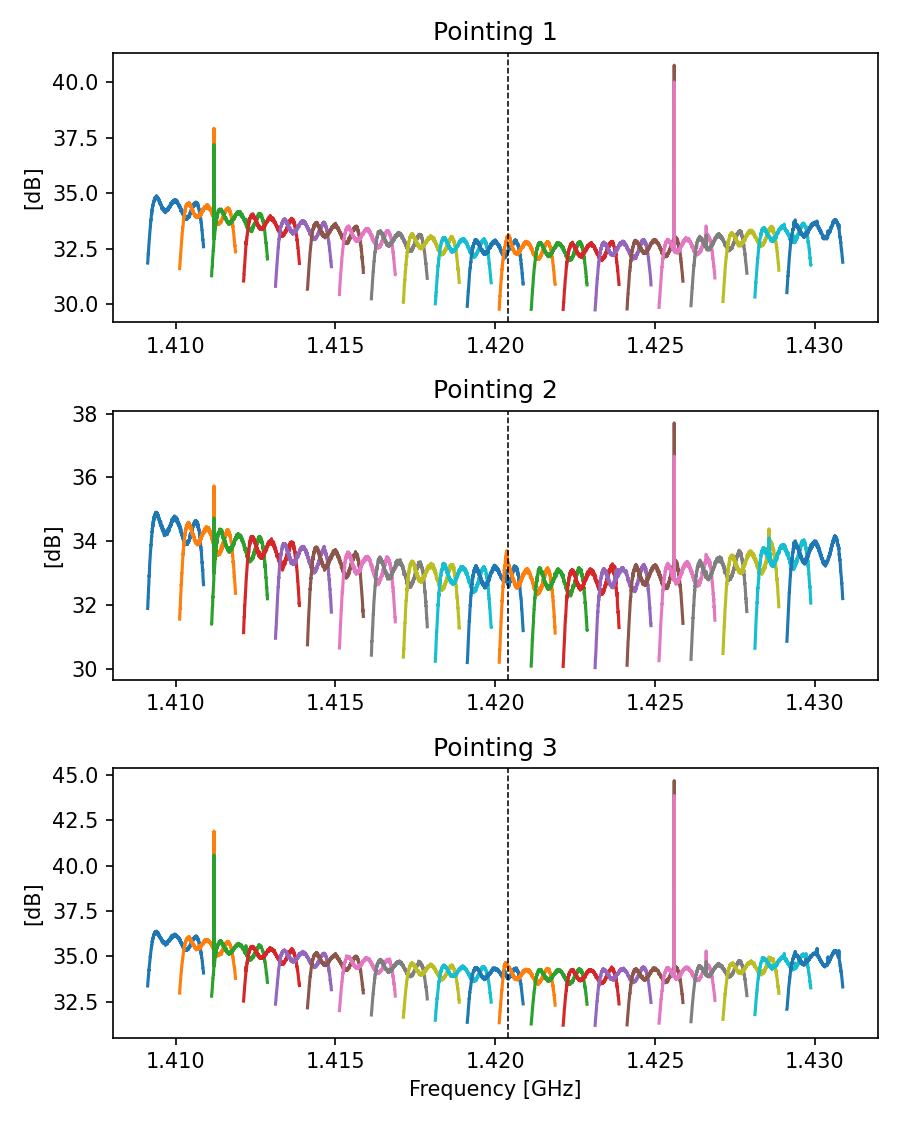

In [4]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) 
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

fig, axs = plt.subplots(ntrials, 1, figsize=stack_figsize)
if ntrials == 1: axs = [axs]
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(f_e.value, c='k', linestyle='--', linewidth=0.75)
 
plt.xlabel('Frequency [GHz]')
plt.tight_layout()

## 2. Basic conversions and corrections

### 2.a. Bandpass and automatic gain correction

After the data is collected from the antenna it passes through a bandpass filter located in our SDR. A bandpass filter is used to isolate a specific frequency range of interest from the broader spectrum of electromagnetic radiation received by the telescope. This filter allows signals within the desired bandpass to pass through with little interference while blocking signals outside that range. However, this bandpass filter has a frequency-dependent response that imparts a shape onto our data. This is the repeating stucture seen in each tuning above. The next cell will calibrate for this bandpass, removing that shape from the data. 

In addition, the SDR will automatically amplify or reduce the signal to ensure the best data possible without saturating the electronics. This is a great feature, but we need to correct for it when analyzing the data. We do this by forcing overlapping data to match levels, on average.

There still may be some overall shape across the whole frequency range caused by frequency dependence of the electronics, but we don't worry about that as our 21-cm signal is in a fairly narrow range. If the 21-cm signal is visible in your data, you should now be able to see it near the line that indicates the rest frequency after running the cell below! You do not need to make any modifications to this cell.

<IPython.core.display.Javascript object>


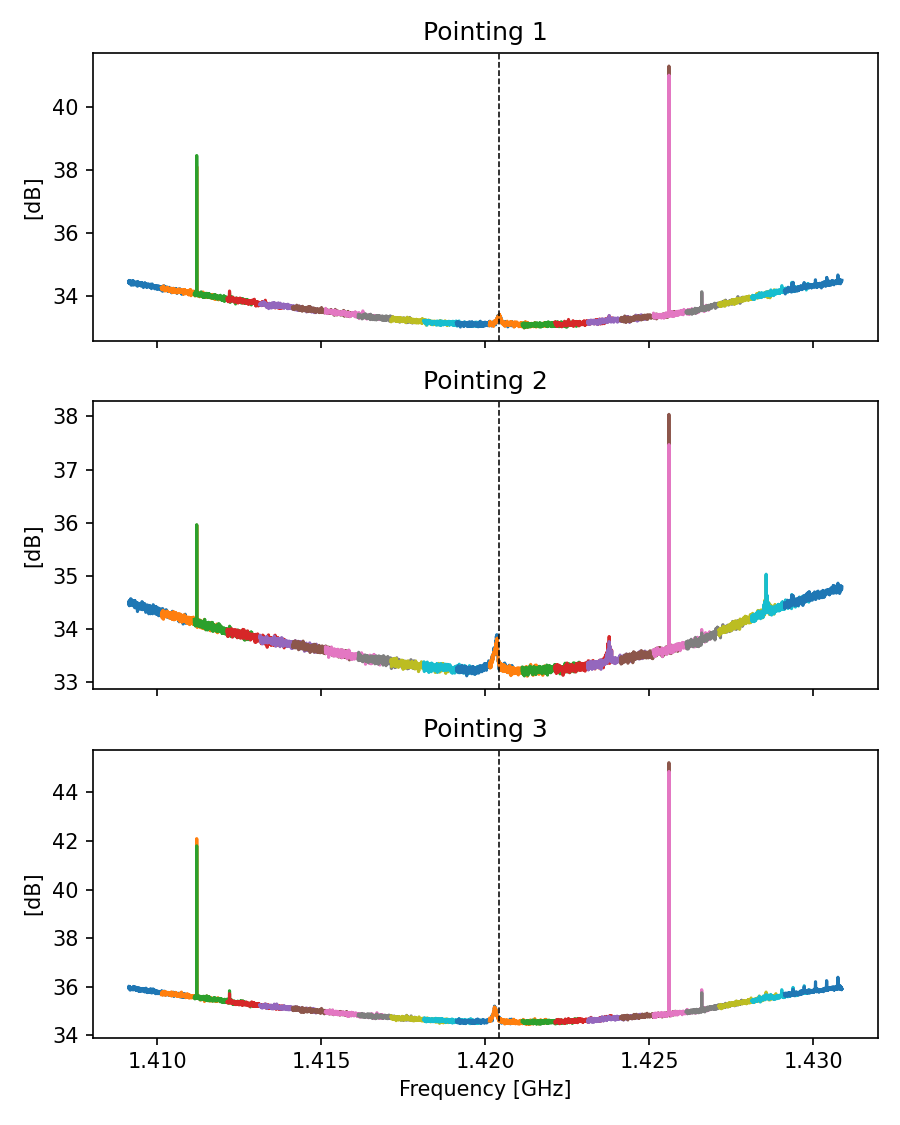

In [5]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) /bps[0]
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

    for k in range(len(spectra[pointing]) - 1):
        spec1 = spectra[pointing][k]
        spec2 = spectra[pointing][k + 1]
        freq1 = freqs[pointing][k]
        freq2 = freqs[pointing][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[pointing][k + 1] = spec2
        
fig, axs = plt.subplots(ntrials, 1, sharex=True, figsize=stack_figsize)
if ntrials == 1: axs = [axs]
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(f_e.value, c='k', linestyle='--', linewidth=0.75)

plt.xlabel('Frequency [GHz]')
plt.tight_layout()

### 2.b. Doppler Shift

The emission line in your plots above may not be centered right on the rest frequency of neutral hydrogen (black dashed line). The shift we see is due to the motion of the earth and the hydrogen gas we are observing.

Have you ever noticed that the sound that comes from a car that is coming towards you sounds different than the sound that comes from the same car as it is moving away from you? That is because the sound waves are being condensed and stretched depending on the car’s position relative to your own. This is an example of the Doppler Effect. 

![Doppler Shift Example](https://flypaper.soundfly.com/wp-content/uploads/2018/01/doppler-effect-header.jpg)

Image Link: https://flypaper.soundfly.com/wp-content/uploads/2018/01/doppler-effect-header.jpg

The same thing occurs with radio waves as objects in the universe move closer and farther away from us. The hydrogen clouds that the telescope detected are moving and in order to find their velocity we have to use the Doppler shift equation. 

$$v=\frac{f_e-f_o}{f_o}c$$

This is the Doppler shift equation where $f_e$ is the rest frequency or the frequency of the hydrogen in a lab when it is not moving, $f_o$ is the frequency we observe, $c$ is the speed of light, and $v$ is the velocity. By using this equation we can get the velocities of the hydrogen clouds in relation to us. The cell below does this calculation. 

In [6]:
velocities = []

for pointing in range(ntrials):
    velocities.append([])
    for k in range(len(freqs[pointing])):
        velocities[pointing].append(freq2vel(freqs[pointing][k] * u.GHz))

### 2.c. Average overlapping data

So far we have plotted each frequency tuning separately. But the tunings overlap, so we should combine the overlapping data to create one spectrum. At this point we also only need a couple tunings because the hydrogen line will be relatively close to the rest frequency. The following cell finds the tunings closest to the rest frequency and combines them.

<IPython.core.display.Javascript object>


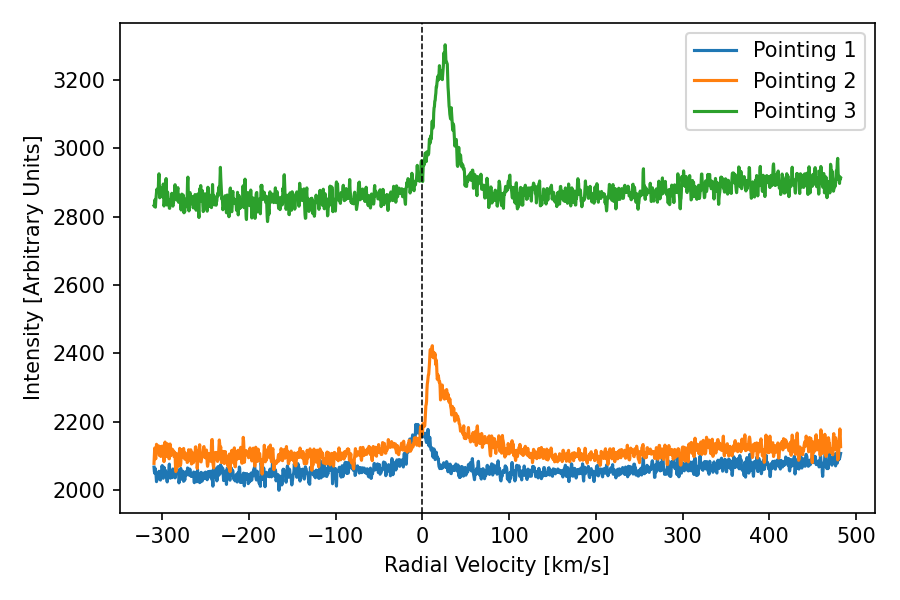

In [7]:
plt.figure(figsize=single_figsize)
unique_vs = []
avg_spectra = []
for pointing in range(ntrials):
    # First find the index of the tuning that contains zero velocity
    k_index, result = find_array_with_number(velocities, pointing, 0)
    
    x1 = velocities[pointing][k_index - 1]
    x2 = velocities[pointing][k_index]
    x3 = velocities[pointing][k_index + 1]
    
    y1 = np.array(10**(spectra[pointing][k_index - 1] / 10))
    y2 = np.array(10**(spectra[pointing][k_index] / 10))
    y3 = np.array(10**(spectra[pointing][k_index + 1] / 10))
    unique_v, avg_y = average_overlapping(x1, y1, x2, y2, x3, y3)
    unique_vs.append(unique_v)
    avg_spectra.append(avg_y)

    plt.plot(unique_v.to(u.km / u.s), avg_y,
             label = f'Pointing {pointing+1}')
    
plt.axvline(0, color ='k', linestyle='--', linewidth=0.75)
plt.ylabel('Intensity [Arbitrary Units]')
plt.legend(loc='best')
plt.xlabel('Radial Velocity [km/s]')

plt.tight_layout()

## 3. Comparing to Survey Data and Calibrating

We nearly have a final spectrum showing the brightness of the hydrogen gas and how fast it's moving. But we need to set the scale appropriately so the y-axis is in physical units. We will do this by comparing against known Milky Way data.

### 3.a. Sky Coordinates and Reference Frames

Now we can check our data against known Milky Way data. The first task is to figure out exactly where in the sky your telescope was pointed.

There are a few ways to identify positions in space. One is the celestial coordinate system. Right Ascension (RA) and Declination (Dec) are a system of coordinates used in astronomy to determine the location of stars, planets, and other objects in the night sky. They are similar to the system of longitude and latitude used to locate places on Earth. Right Ascension corresponds to longitude and Declination to latitude. 

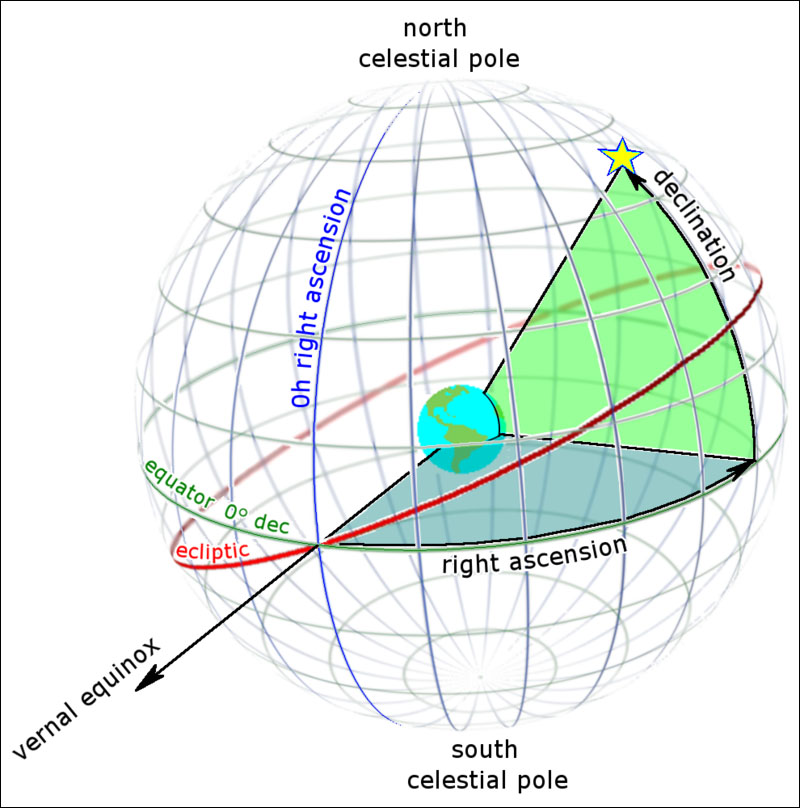
Image link: https://skyandtelescope.org/astronomy-resources/right-ascension-declination-celestial-coordinates/

Another is the galactic coordinate system. Galactic coordinates are a system of coordinates used in astronomy to determine the location of objects in the Milky Way galaxy. The system uses the Sun as its center, with the primary direction aligned with the approximate center of the Milky Way galaxy.

There are two coordinates in this system: galactic longitude ($l$) and galactic latitude ($b$). Galactic longitude is measured with the primary direction from the Sun to the center of the galaxy in the galactic plane, while galactic latitude measures the angle of the object above the galactic plane. 

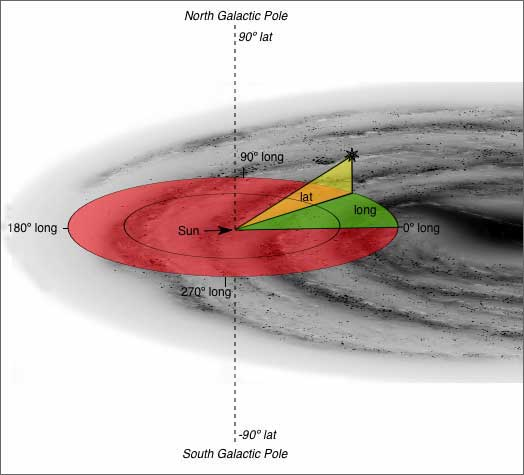
Image link:https://astronomy.ua.edu/undergraduate-program/course-resources-astronomy/lab-exercise-8-cosmic-distributions-and-the-galactic-ecology/1293-2/

The images below show the telescope's line of sight (top) and field of view (FoV, bottom) from two perspectives, one looking at the galaxy from a top-down view, and the other showing the area of the sky observed from Earth's surface. The FoV is the extent of the observable area measured in degrees that the telescope can see. Within the direction that the telescope is pointed towards, there are multiple neutral hydrogen clouds. If you look at the line of sight figure, you can see that the arrows cross through multiple parts of the galaxy. Gas from these areas will be moving at different velocities and directions. 

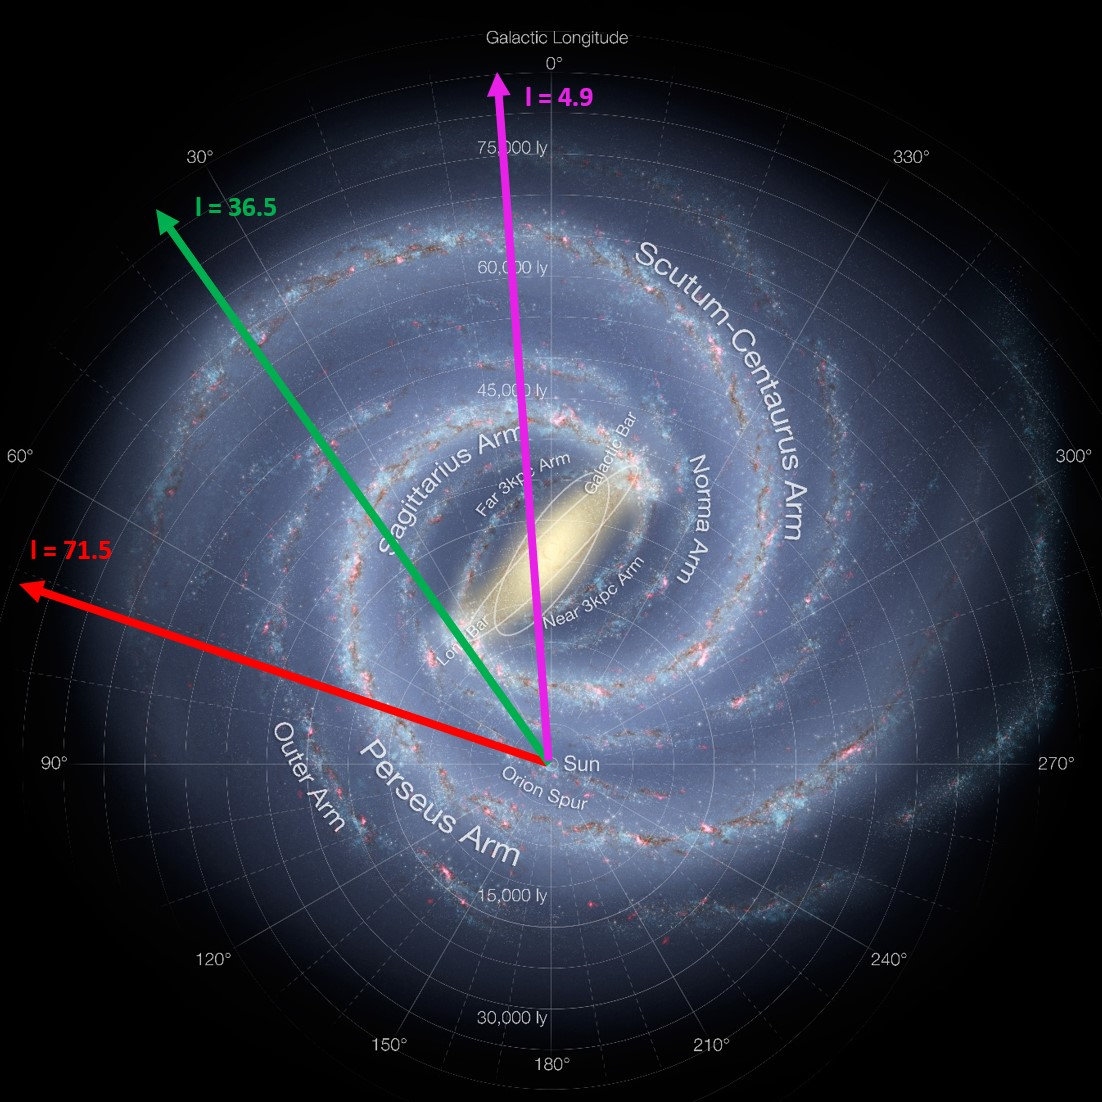

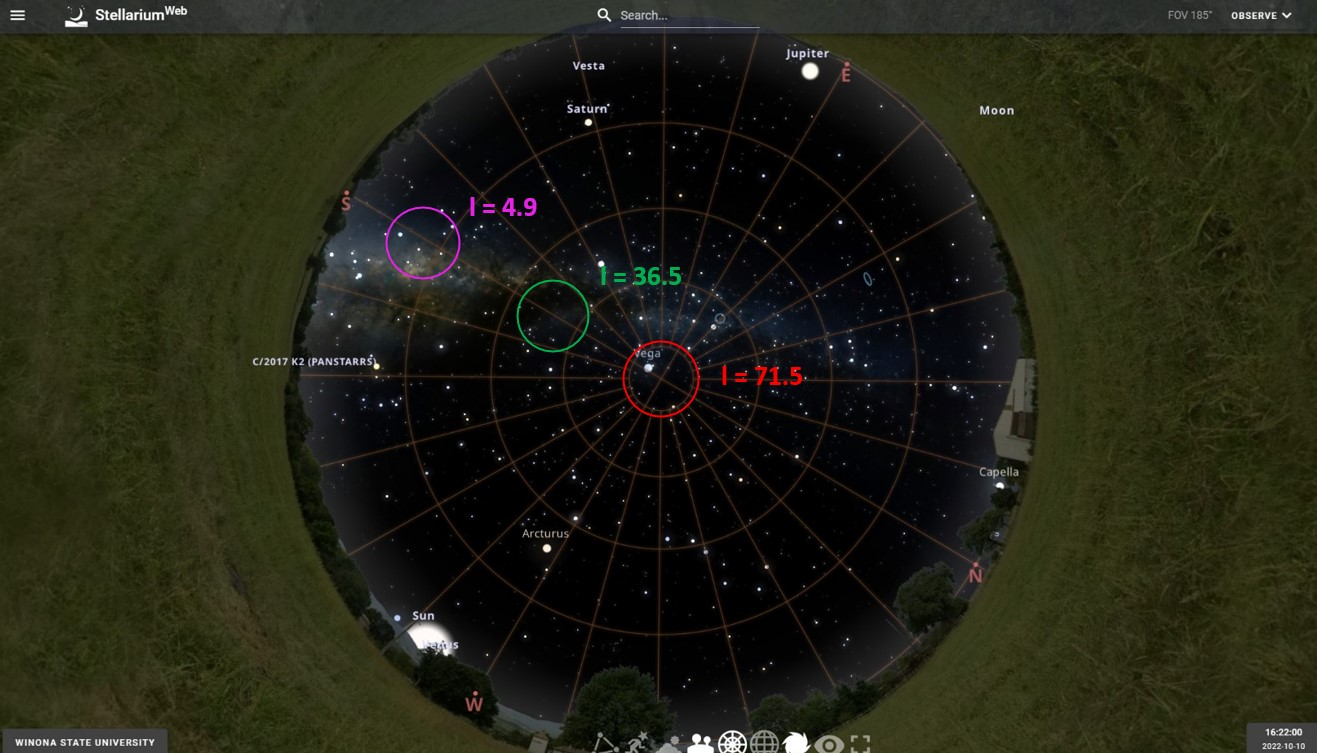

We need to use information about the observations to determine where in the galaxy we were pointed. Below is the information about the test data used here, taken in Winona Minnesota on October 8th, 2022.

>Pointing 1:
Long edge of horn oriented E-W
pointed 0 deg N-S, 4 deg to the East
Default observing parameters
Started 6:12pm

>Pointing 2:
Tilted down, 37 deg S of vertical
Freqs 1410-1431
Started 6:25pm

>Pointing 3:
Laying down toward S, elevation=17deg
Same freqs as Trial 2
Started 6:30pm

The cell below does some convienient variable setting for later. You will need to make some modifications to this cell if you want to use your own data. The first three variables (`Observation_longitude`, `Observation_latitude`, and `Observation_elevation`) correspond to the longitude of the observation location in degrees, the latitude of the observation location in degrees, and the elevation of the observation location in meters. You need to find these values for your observing location if you are not using the test data. You do not need to wrap these in quotes, as they are not the string type data we used before. These values are what is called a 'float' in python, which is a type of number.

The next three variables are lists with data that correspond to each of your pointings. `Observation_azimuths` is the azimuthal angle of your observation in degrees, `Observation_altitudes` is the altitude angle of your observation in degrees, and `Observation_datetimes` is the date and time in the format `YYYY-MM-DDThh:mm:ss`. You need to make sure to use the UTC time zone, which you can find an online converter to obtain.


In [8]:
### Pointing Dict setup 
Observation_longitude = -91.64419  # degrees
Observation_latitude = 44.04672  # degrees
Observation_elevation = 200  # meters
Observation_azimuths = [90, 180, 180]  # degrees
Observation_altitudes = [86, 53, 17]  # degrees
Observation_datetimes = ['2022-10-8T23:12:00', '2022-10-8T23:25:00', '2022-10-08T23:30:00']

The next cell uses this observation information to find the galactic coordinates for each pointing. It will print the coordinates out for reference, and it will save them for later. 

In addition, because the earth is always moving (rotating, moving around the sun), astronomers use the Local Standard of Rest (LSR) frame to measure the motion of objects in our galaxy, the Milky Way, with reference to our local solar neighborhood. This frame removes the peculiar motion of the earth and sun, and puts the observer stationary with the mean flow of motion in our part of the Milky Way. The cell below also find the velocity adjustment needed to account for this reference frame and uses it to transform our velocity axes.

You do not need to make any modifications to this cell.

In [9]:
galactic_ls = []
galactic_bs = []
v_adjustments = []

for n in range(ntrials):
    galactic_coords, v_adj = get_gal_coords(Observation_longitude, Observation_latitude,
                                            Observation_elevation, Observation_datetimes[n],
                                            Observation_altitudes[n], Observation_azimuths[n],
                                            return_vadj=True)
    l = galactic_coords.l
    b = galactic_coords.b
    galactic_ls.append(l.degree)
    galactic_bs.append(b.degree)
    v_adjustments.append(v_adj)
    unique_vs[n] -= v_adj
    print(f'Pointing {n + 1}')
    print(f'\t Galactic longitude: {round(l.degree, 2)}\u00b0')
    print(f'\t Galactic latitude:  {round(b.degree, 2)}\u00b0')
    print(f'\t Velocity adjustment: {round(v_adj.value, 2)} km/s')

Pointing 1
	 Galactic longitude: 72.61°
	 Galactic latitude:  20.85°
	 Velocity adjustment: -7.56 km/s
Pointing 2
	 Galactic longitude: 36.52°
	 Galactic latitude:  8.48°
	 Velocity adjustment: 7.13 km/s
Pointing 3
	 Galactic longitude: 4.89°
	 Galactic latitude:  -8.97°
	 Velocity adjustment: 19.06 km/s


### 3.b. LAB Survey data

Now that we know where the telescope was pointed and have accounted for the motion of the earth and sun, we can read in data from other surveys to compare.

We will use the Leiden/Argentine/Bonn (LAB) Survey. The LAB Survey is a project that mapped the 21-cm gas with two telescopes, one in the Netherlands and one in Argentina. The LAB survey has published a simulator based on this data, which you can use to extract the expected spectrum for the coordinates your telescope was pointed at. We can use this spectrum to calibrate our spectra, and then compare the shapes to see if they match.

With your galactic coordinates in hand, head to this website: https://www.astro.uni-bonn.de/hisurvey/euhou/LABprofile/index.php .
This database allows you to extract hydrogen profiles from the Leiden/Argentine/Bonn (LAB) Survey. 

Input the galactic coordinates and 20$^\circ$ for the effective beamsize FWHM. The beam size of a telescope is the angular size of the area that the telescope can "see" at once. For CHART, the beam size is 25 degrees, however we input 20 degrees due to the limitations of the simulator. 

Download the HI profile files and place them somewhere on your computer near your data. If you are using the radiolab.winona.edu server, you can upload the data in the Jupyter Hub interface. 

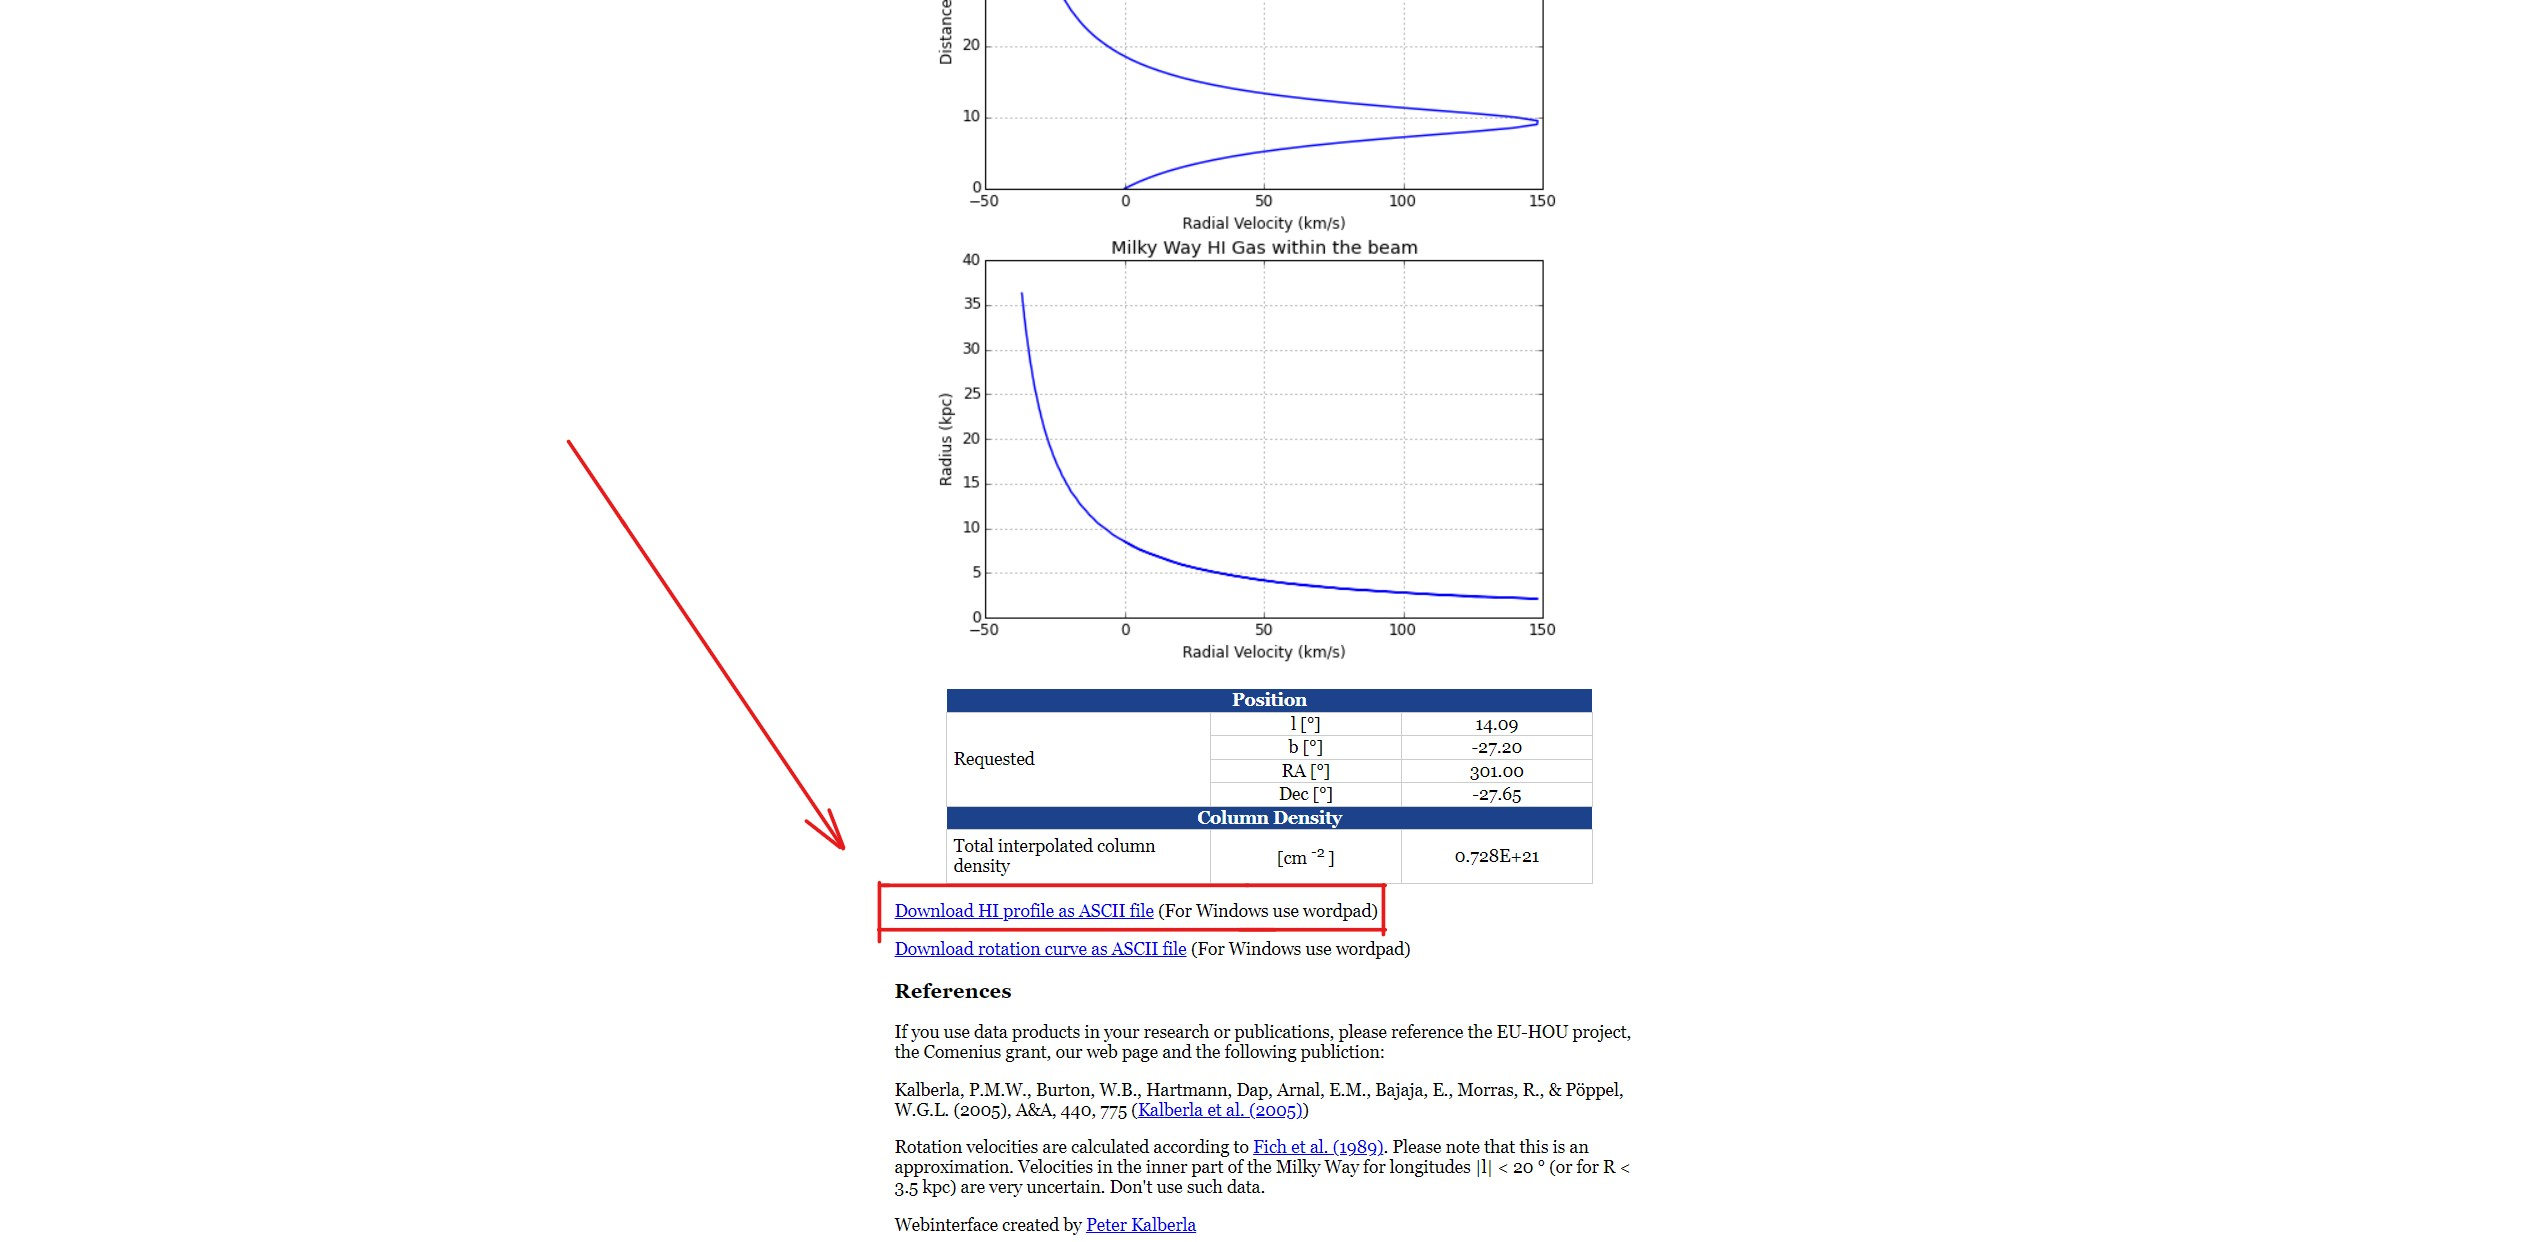



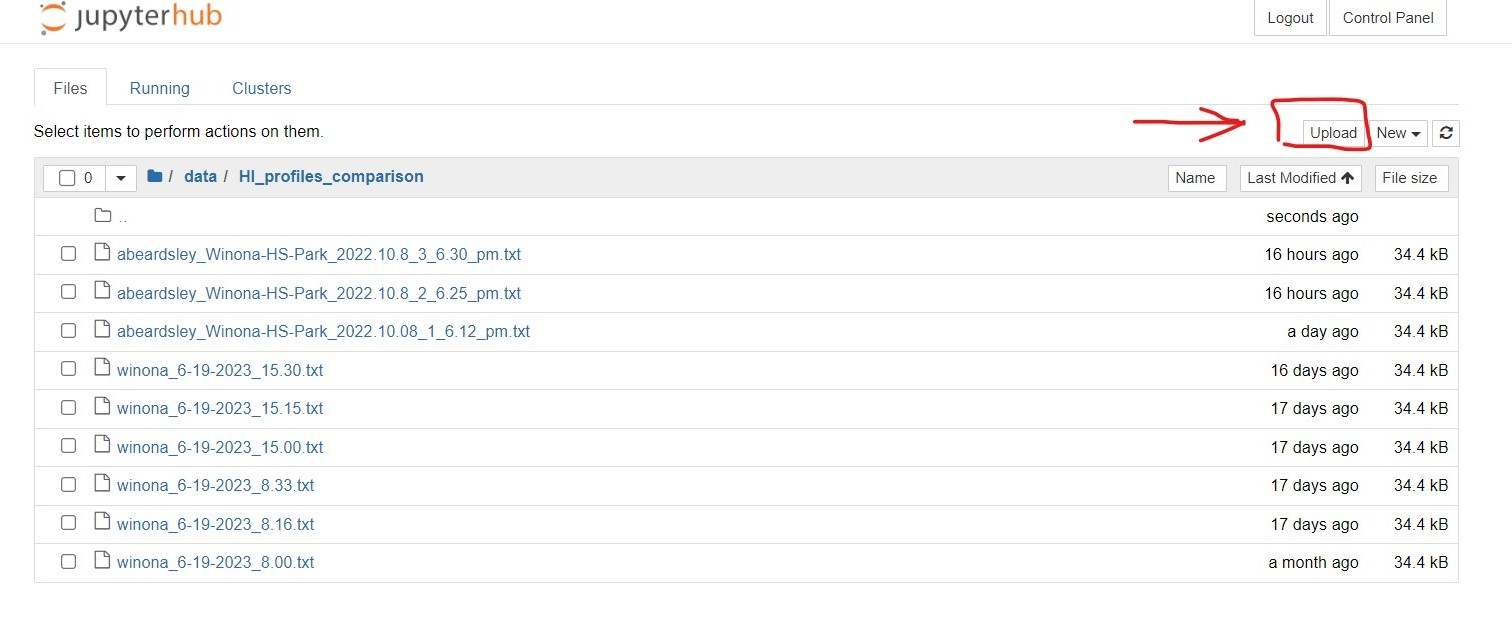

Make sure you get one HI profile for each pointing, and update the `comps` list below with their locations.
The file names need to be in the same order as the pointing they belong to! Then, run the cell, and the file locations will be saved for later.

In [10]:
comps = ['test_data/abeardsley_Winona-HS-Park_2022.10.08_1_6.12_pm.txt', 
         'test_data/abeardsley_Winona-HS-Park_2022.10.8_2_6.25_pm.txt', 
         'test_data/abeardsley_Winona-HS-Park_2022.10.8_3_6.30_pm.txt']

The next cell plots the survey data which should look qualitatively like our data, but the vertical axis will be quite different. We will fix that in the next section when we calibrate our data.

<IPython.core.display.Javascript object>


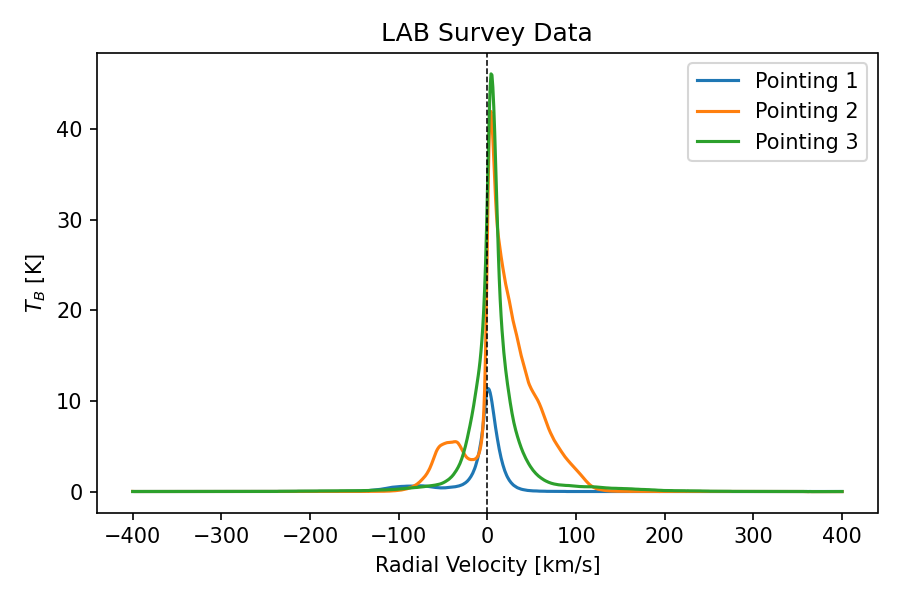

In [11]:
plt.figure(figsize=single_figsize)
model_vs = []
model_Ts = []
for pointing in range(ntrials):
    sh_comp = pd.read_table(comps[pointing],skiprows=[0,1,2,3],names=['v_lsr', 'T_B', 'freq', 'wavel'], delimiter = '\s+')
    model_vs.append(np.array(sh_comp['v_lsr']))
    model_Ts.append(np.array(sh_comp['T_B']))
    
    plt.plot(model_vs[pointing], model_Ts[pointing],
         label = f'Pointing {pointing+1}')
    
plt.axvline(0, color ='k', linestyle='--', linewidth=0.75)
plt.ylabel('$T_B$ [K]')
plt.legend(loc='best')
plt.xlabel('Radial Velocity [km/s]')

plt.title('LAB Survey Data')
plt.tight_layout()


### 3.c. Calibrate against a model

The cell below will perform the last calibration step  using the simulated spectrum from the LAB survey. Data taken with a radio telescope has effects imposed on it by the instrument. One of these effects is called the telescope 'gain'. The gain is any amplification applied to the astronomical signal by the telescope, which happens, for example, with the analog amplifier we use for CHART. In order to know what the original astronomical signal looks like, we need to calibrate for how much gain was applied to the signal. There are a number of ways to do this calibration, but here we will use the LAB survey as a 'sky model'. Using a known measurement of the sky, we can adjust our signal amplitude to be the correct level for the known Milky Way at our coordinates. 

We also need to adjust for something called 'noise'. Noise is any generated signal that we see that is not our astronomical signal, which can come from, for example, the thermal noise of our electronics. This noise is added to our data, so we call it an 'additive' source, while the gain is a multiplication. We then have an equation that looks like:

`(CHART data) = (Astronomical signal) * Gain + Noise `

and we want to find out the gain and noise parameters so we can rearrange the equation to get the real astronomical signal:

`(Astronomical signal) = ((Chart data) - Noise)/Gain `

This is a simplification of the real world, and we make assumptions here, like the noise and gain being the same for every frequency. However, it works well to get a simple calibration.  The gain and noise will be automatically be calculated and applied by the next cell. 

Run the cell below. The CHART data and simulated model data are plotted as different colors. Then, you can evaluate how well your data matches the shape of the model!  

<IPython.core.display.Javascript object>


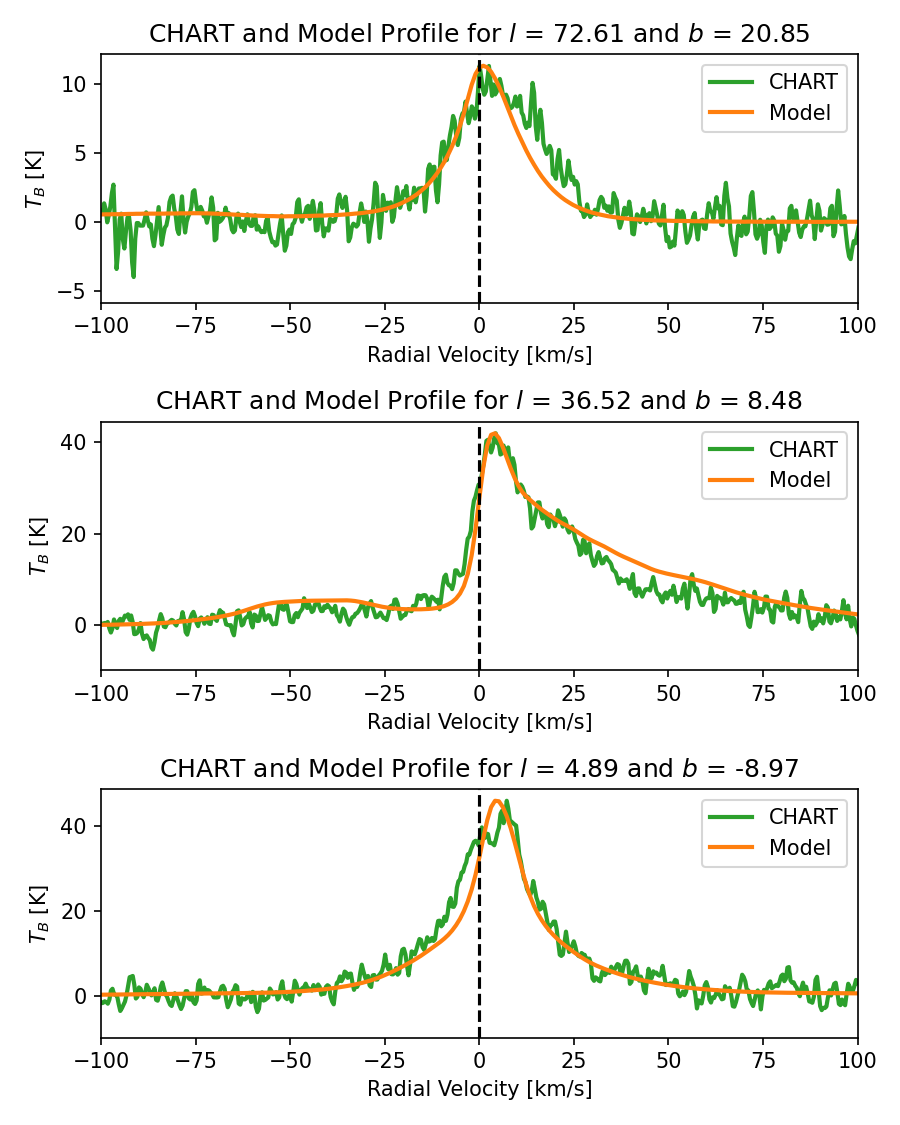

In [12]:
fig, axs = plt.subplots(ntrials, figsize=stack_figsize)
if ntrials == 1: axs = [axs]
noises = []
gains = []
cal_spectra = []

for pointing in range(ntrials):

    vneg75 = np.argmin(np.abs(unique_vs[pointing].to(u.km/u.s).value+75))
    vneg100 = np.argmin(np.abs(unique_vs[pointing].to(u.km/u.s).value+100))
        
    noise = np.mean(avg_spectra[pointing][vneg100:vneg75])
    gain = max(avg_spectra[pointing]-noise)/(max(model_Ts[pointing]))
    
    noises.append(noise)
    gains.append(gain)
    cal_spectra.append((avg_spectra[pointing] - noise) / gain)
    
    axs[pointing].plot(unique_vs[pointing].to(u.km/u.s), cal_spectra[pointing], 'tab:green', linewidth=2, label = 'CHART')
    axs[pointing].plot(model_vs[pointing],model_Ts[pointing],'tab:orange', linewidth=2, label = 'Model')

    axs[pointing].axvline(0, color ='k', linestyle='--')
    axs[pointing].set_xlim(-100,100)
    axs[pointing].set_ylabel('$T_B$ [K]')
    axs[pointing].legend(loc='best')
    axs[pointing].set_xlabel('Radial Velocity [km/s]')
    axs[pointing].set_title('CHART and Model Profile for $l$ = '
                            + str(round(galactic_ls[pointing], 2))
                            + ' and $b$ = '
                            + str(round(galactic_bs[pointing], 2)))

plt.tight_layout()

What do you notice here? How well do you think your fits worked? What sources of error can you come up with?

## 4. Making a Rotation Curve 

Now we will use the calibrated data to compute an approximate rotation curve of the Milky Way galaxy. A rotation curve is a plot that shows how the orbital velocity of objects in a galaxy changes with their distance from the center of the galaxy. In other words, it shows how fast different parts of a galaxy are rotating around its center. Rotation curves are essential tools for studying the structure and dynamics of galaxies, as well as for understanding the distribution of mass within galaxies. By analyzing the shape of a galaxy’s rotation curve, scientists can learn about the distribution of visible and dark matter within the galaxy. 

The figure below shows a rotation curve of the M33 galaxy, constructed from actual measurements of stars and hydrogen clouds. The "expected from visible disk" curve shows what the expected rotation curve of M33 would look like if we added up all the matter we can see and compute what the rotation curve should look like. You will notice a discrepancy. This tells us that our model of rotation curves is missing something, and astronomers believe that something to be dark matter causing the rotation at the edges of galaxies to be much faster than expected.

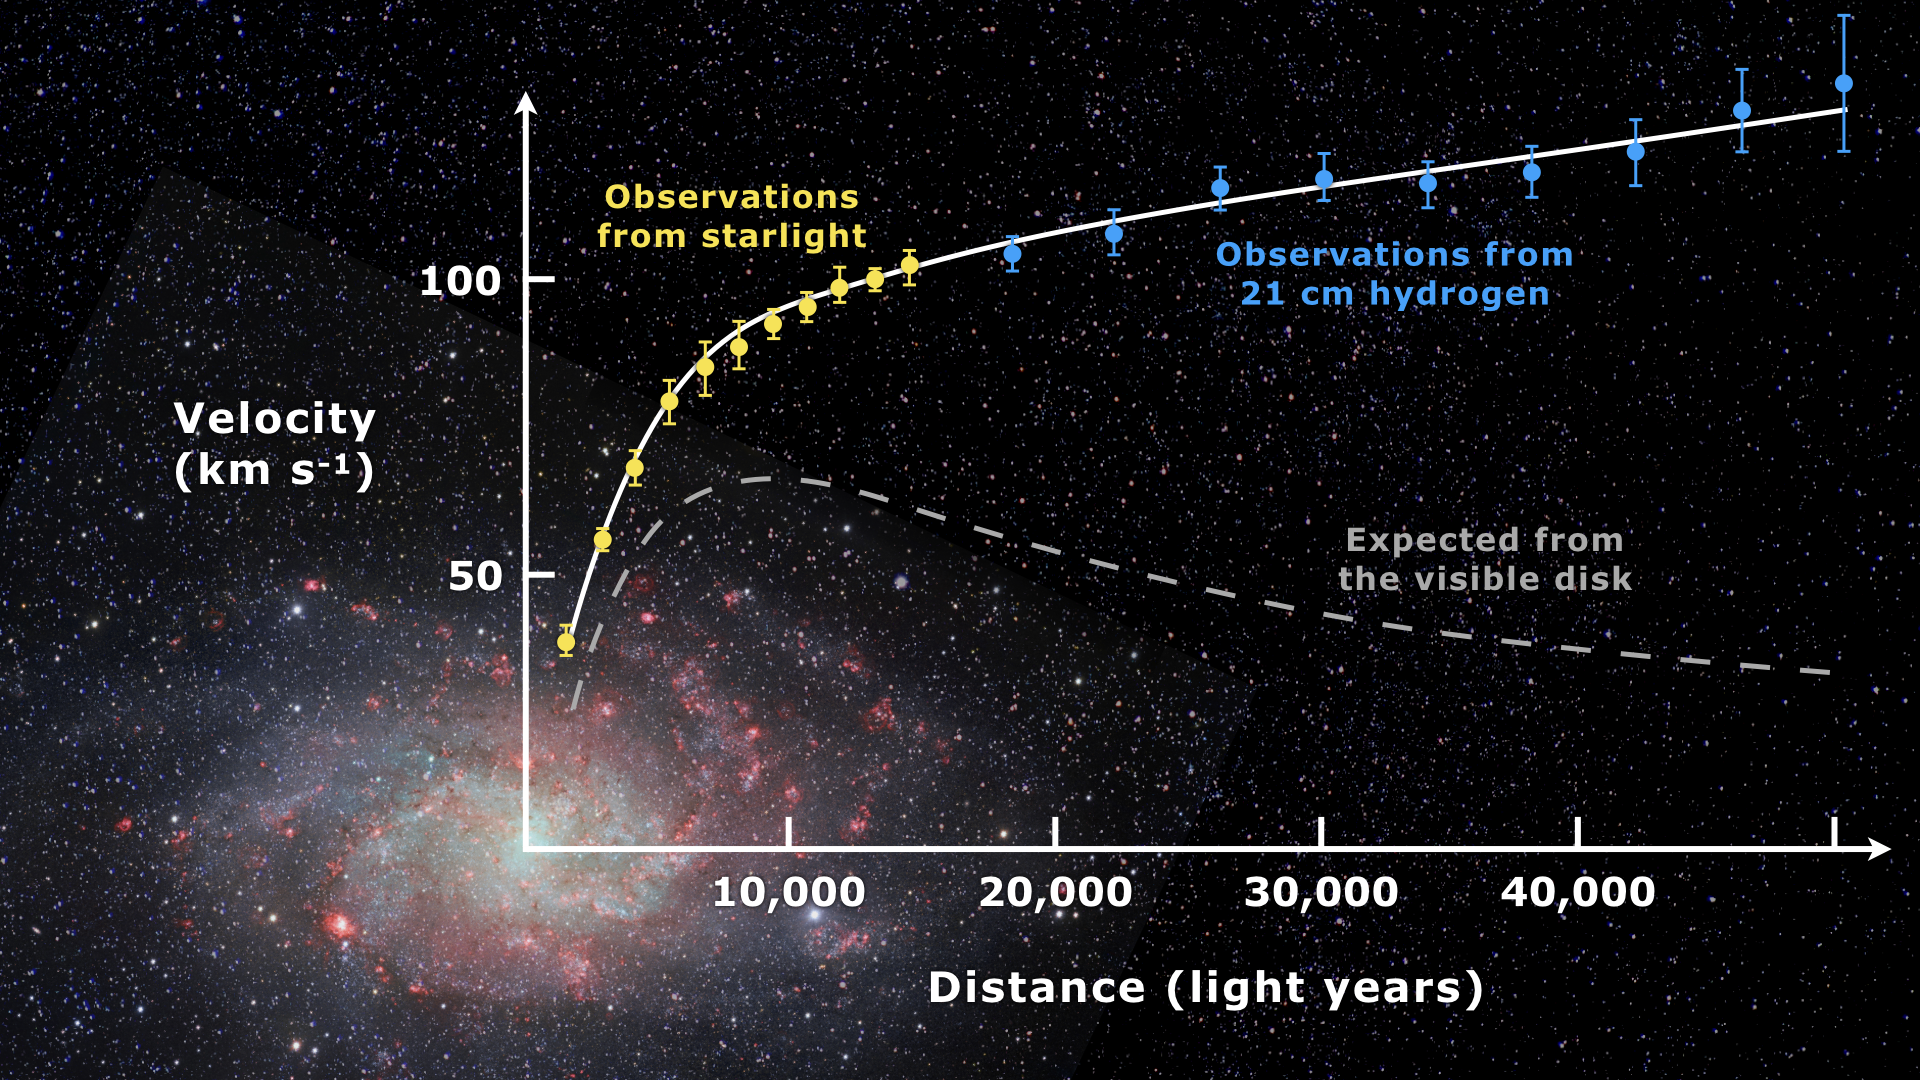
Image link: https://en.wikipedia.org/wiki/Galaxy_rotation_curve

### 4.a. Tangent point method

Referring back to the line of sight figure included again below, you will notice that each line of sight crosses multiple structures in the Milky Way. For example, the l=36.5 line crosses the Sagittarius arm as well as the Scutum-Centaurus arm. Additionally, you will pick up some local neutral hydrogen surrounding our local neighborhood that moves roughly constant with the LSR. This means that there is a good chance there are multiple hydrogen clouds at different distances in your data. In order to make a rotation curve, we need to figure out how to seperate out those hydrogen clouds and assign them to a distance. For this, we will use a method called the "tangent point method."

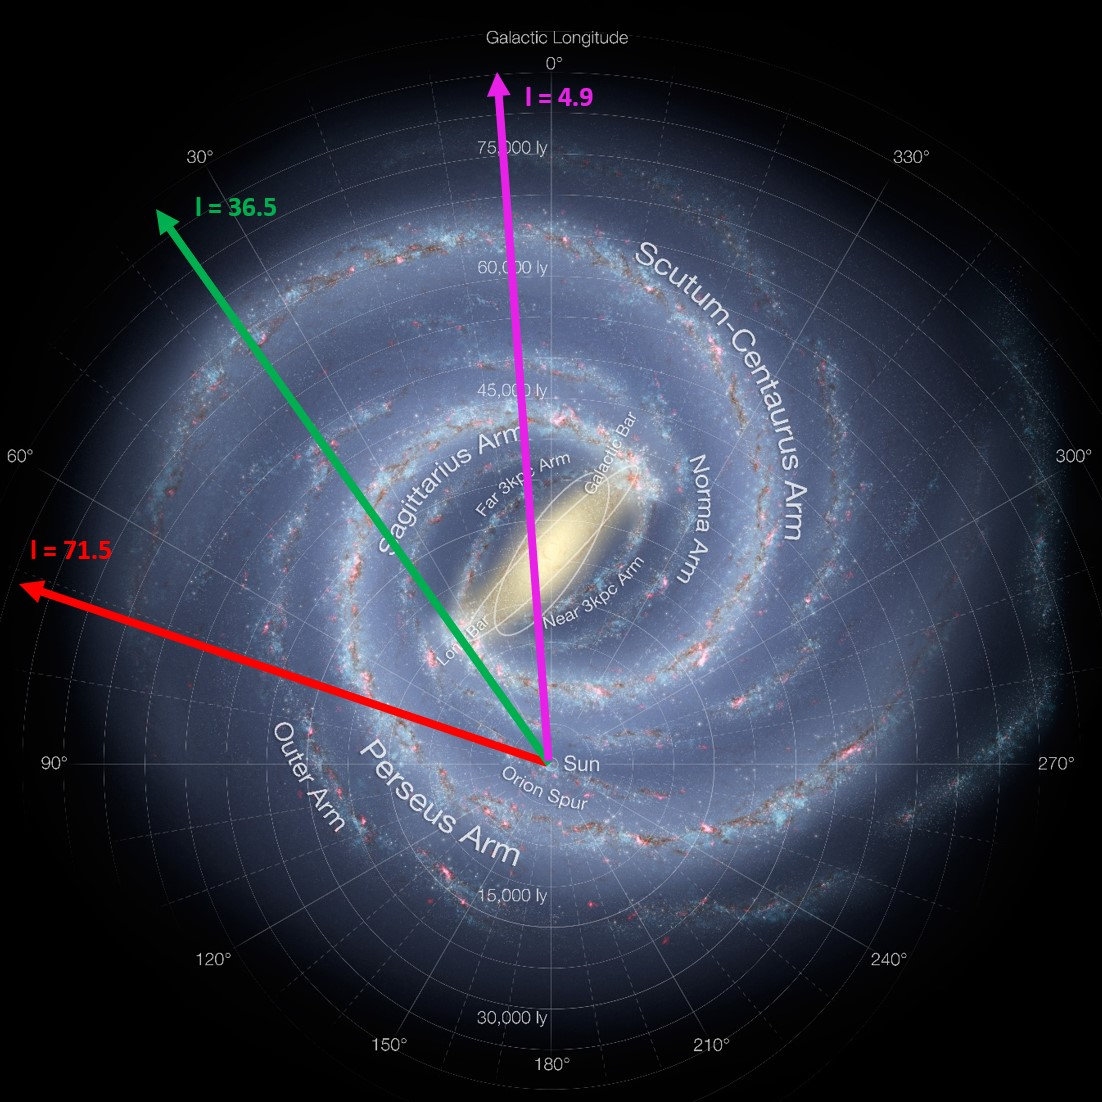

 One of the difficulties in measuring a rotation curve is that it is difficult to assign a specific velocity to a specific distance when observing multiple clouds along a line of sight. The tangent point method takes advantage of a few assumptions about the way our galaxy rotates and uses simple geometry. Our knowledge of the basic rotation of the Milky Way suggests that for matter within a solar distance from Galactic Center ($R$<$R_{0}$), the velocity reduces with distance from Galactic Center. The solar radius has some uncertainty, but is estimated as about 8 kpc from Galactic center. The figure below shows the geometry of the tangent point method, which will also be explained mathematically.
 


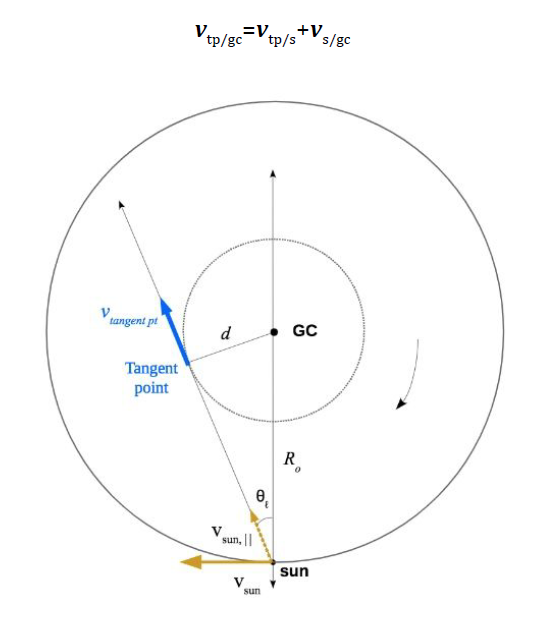


Looking at the geometry of the figure and the velocity vectors, we can see that the highest velocity away from the observer is located at the tangent point along the line of sight, which is the point where a circle drawn around the Galactic Center would intersect the line of sight. Since we have the angle of our line of sight away from the Galactic Center ($\theta_l$), which is just the galactic longitude, we can calculate the distance $d$ from the Galactic center. Then, we associate $d$ with the highest velocity in our data, and we now have a distance-velocity association! To get $d$: 

$$
    d = R_{0} \sin(\theta_l)
$$

where $R_{0}$ is the distance from the sun to Galactic Center and $\theta_l$ is the galactic longitude of our observation. We now know what distance our highest velocity cloud is at. However, we want that velocity with respect to the Galactic Center, not the observer. Then, to get the velocity of the cloud with respect to Galactic Center $v_{tp/gc}$, we have

\begin{equation}
v_{tp/gc} = v_{tp/s} + v_{sun,||} = v_{tp/s} + v_{sun} \sin(\theta_l)
\end{equation}

where $v_{tp/s}$ is the velocity we measure with out instrument,  $v_{sun}$ is the solar velocity with respect to Galactic Center, which we know to be approximately 220 km/s, and $v_{sun,||}$ is the component of $v_{sun}$ that is parallel to the direction of our observation.

It is important to note that this geometry only works for lines of sight within the first and fourth Galactic quadrants. Galactic coordinates have four quadrant designations: $0^\circ<\theta_l<90^\circ$ is the first quadrant, $90^\circ<\theta_l<180^\circ$ the second, $180^\circ<\theta_l<270^\circ$ the third, and $270^\circ<\theta_l<360^\circ$ the fourth. Try to see for yourself why the geometry doesn't work for the second and third quadrants. 

At the moment, we do not have a tutorial for rotation curves with quadrants 2 and 3, so you will not be able to use pointings in those quadrants here.

### 4.b. Finding highest velocity clouds

Now that we have our equations, we want to find the highest velocity cloud in our data to input into the tangent point equations. How do we know what the highest velocity in the data is?

We will approximate our velocity profiles as combined product of multiple Gaussian curves. The Gaussian curve makes a nice approximation for many types of natural phenomena, since it follows a normal distribution. Each of these Gaussians will represent a single cloud in our data, and the highest velocity Gaussian will be our tangent point cloud. For simplicity, you should only need up to four Gaussian curves to fit the data since it is unlikely that the antenna picked up more than four distinct clouds. It is important to remember that you might not need four.

The cell below will plot the data for the first pointing, and print some interactive sliders for you to use. The sliders correspond to 4 different Gaussian curves whose combined sum is the fifth curve. You can change the colors to your liking using the drop down menu. The “a” variable corresponds to the height of the Gaussian curve, the “b” variable corresponds to its location on the x-axis. And the “c” variable corresponds to the width of the curve. Play around with the a, b, and c values for each of the four curves, and try to match the 5th curve to your data. Once you have a fit you are happy with, write down all of the "b" values, which tell you the velocity the Gaussian curve is centered at. This time, we have three seperate cells for each of our three pointings, since the plots are interactive. If you have more than three pointings, you can copy and paste the cell below again. You will need to change the "pointing" variable to be equal to the number of the pointing you are looking at. Python indexes from 0, so pointing 1 is actually 0, and pointing 2 is 1, and so on. If you want to add a fourth pointing, copy and paste the cell and then change pointing = 3. Do that as many times as you need, and fit all your pointings.

<IPython.core.display.Javascript object>


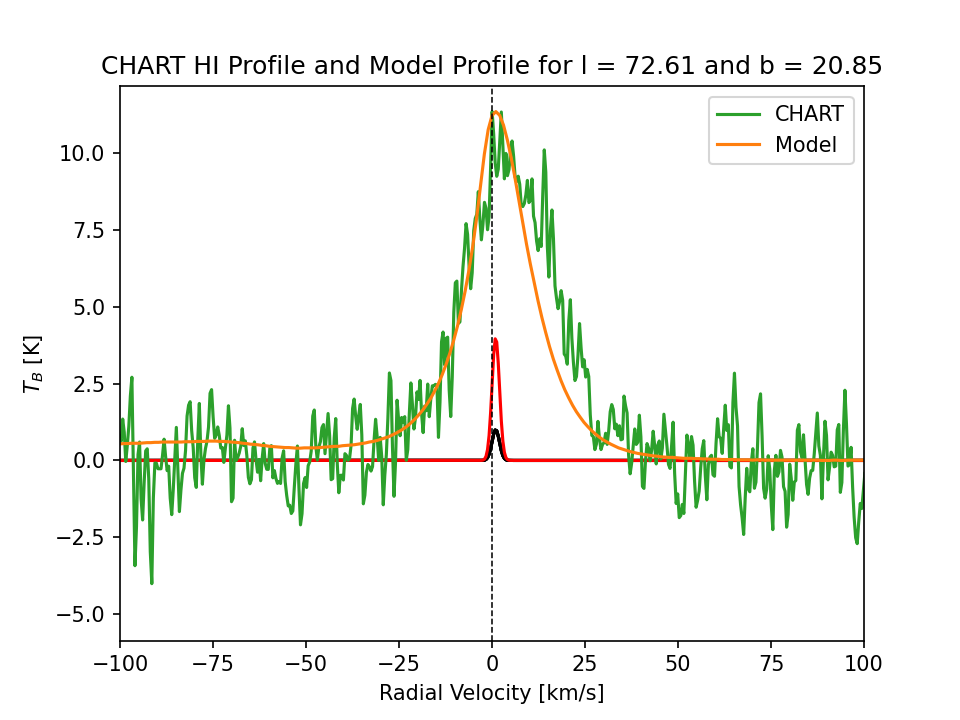

interactive(children=(FloatSlider(value=1.0, description='a1', min=-100.0, step=1.0), FloatSlider(value=1.0, d…

Text(0.5, 1.0, 'CHART HI Profile and Model Profile for l = 72.61 and b = 20.85')

In [13]:
pointing = 0

ax=interactive_plot(unique_vs[pointing].to(u.km/u.s).value)
ax.plot(unique_vs[pointing].to(u.km/u.s), cal_spectra[pointing], 'tab:green', label = 'CHART')
ax.plot(model_vs[pointing],model_Ts[pointing],'tab:orange', label = 'Model')
plt.axvline(0, color ='k', linestyle='--', linewidth=0.75)
plt.xlim(-100,100)
ax.set_ylabel('$T_B$ [K]')
ax.legend(loc='best')
plt.xlabel('Radial Velocity [km/s]')
plt.title('CHART HI Profile and Model Profile for l = ' + str(round(galactic_ls[pointing], 2)) + ' and b = ' + str(round(galactic_bs[pointing], 2)) )


<IPython.core.display.Javascript object>


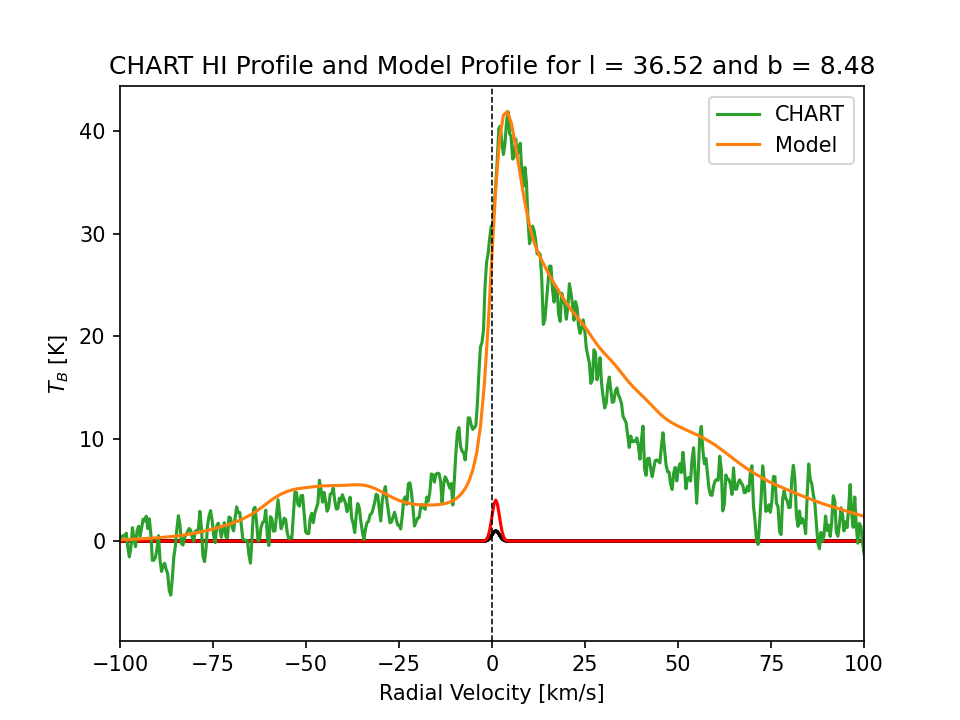

interactive(children=(FloatSlider(value=1.0, description='a1', min=-100.0, step=1.0), FloatSlider(value=1.0, d…

Text(0.5, 1.0, 'CHART HI Profile and Model Profile for l = 36.52 and b = 8.48')

In [14]:
pointing = 1

ax=interactive_plot(unique_vs[pointing].to(u.km/u.s).value)
ax.plot(unique_vs[pointing].to(u.km/u.s), cal_spectra[pointing], 'tab:green', label = 'CHART')
ax.plot(model_vs[pointing],model_Ts[pointing],'tab:orange', label = 'Model')
plt.axvline(0, color ='k', linestyle='--', linewidth=0.75)
plt.xlim(-100,100)
ax.set_ylabel('$T_B$ [K]')
ax.legend(loc='best')
plt.xlabel('Radial Velocity [km/s]')
plt.title('CHART HI Profile and Model Profile for l = ' + str(round(galactic_ls[pointing], 2)) + ' and b = ' + str(round(galactic_bs[pointing], 2)) )


<IPython.core.display.Javascript object>


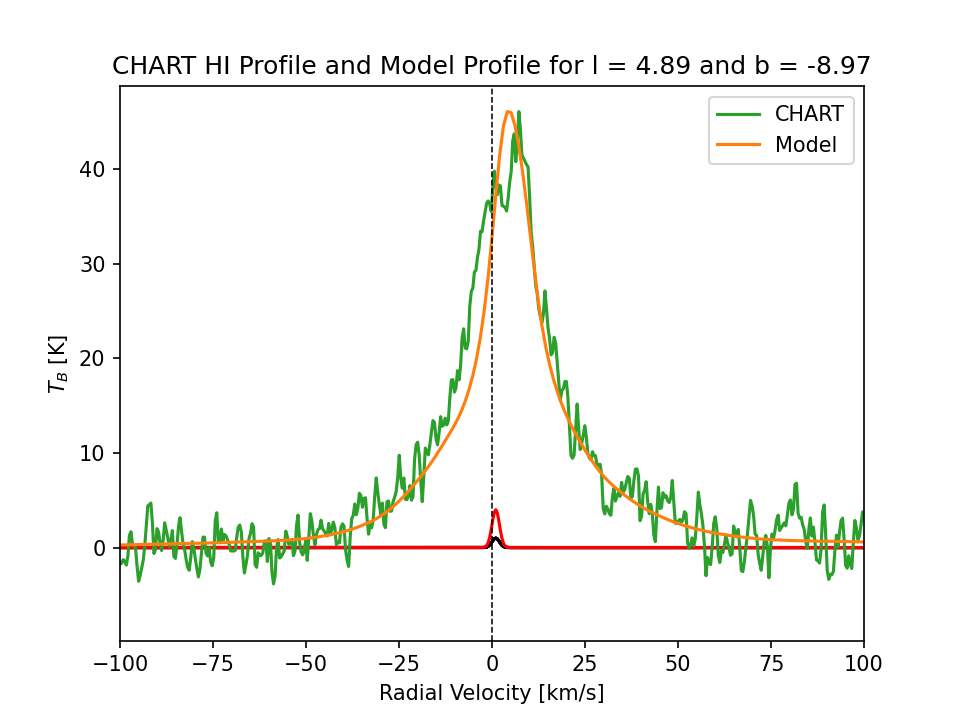

interactive(children=(FloatSlider(value=1.0, description='a1', min=-100.0, step=1.0), FloatSlider(value=1.0, d…

Text(0.5, 1.0, 'CHART HI Profile and Model Profile for l = 4.89 and b = -8.97')

In [15]:
pointing = 2

ax=interactive_plot(unique_vs[pointing].to(u.km/u.s).value)
ax.plot(unique_vs[pointing].to(u.km/u.s), cal_spectra[pointing], 'tab:green', label = 'CHART')
ax.plot(model_vs[pointing],model_Ts[pointing],'tab:orange', label = 'Model')
plt.axvline(0, color ='k', linestyle='--', linewidth=0.75)
plt.xlim(-100,100)
ax.set_ylabel('$T_B$ [K]')
ax.legend(loc='best')
plt.xlabel('Radial Velocity [km/s]')
plt.title('CHART HI Profile and Model Profile for l = ' + str(round(galactic_ls[pointing], 2)) + ' and b = ' + str(round(galactic_bs[pointing], 2)) )


### 4.c. Plotting the rotation curve

Now that you have separated the individual clouds in the data it is time to identify the highest-velocity cloud moving away from the observer. The terminology "highest velocity cloud" may have a sign difference depending on what galactic quadrant you're looking at.

If your data is in the first quadrant ($0^\circ<l<90^\circ$), then you are looking for the most positive "b" value from your curves above. If your data is in the fourth quadrant ($270^\circ<l<360^\circ$), then you are looking for the most *negative* "b" value from your curves. The reason for this disparity has to do with the direction the clouds are moving. Clouds in the first quadrant are moving away from us and are therefore redshifted. When using the Doppler equation these clouds will give us positive values. On the other hand, clouds in the fourth quadrant are moving toward us and are therefore blueshifted.  When using the Doppler equation these clouds will give us negative values. The number you will use is the absolute value of the velocity you get from this process. 

You should have written down the b values for all of your pointings.  Pick the highest positive or negative depending on the appropriate quadrant for each pointing.

The first line below will need to be modified to have the velocities you picked. Change the list to have the velocity values you found (i.e. the largest "b" values from the dropdown menus). Make sure you input them in the order of the pointings.

The cell will calculated the distance and velocity with respect to galactic center, and plot your rotation curve. It will also plot known rotation curve values from other scientific experiments underneath. You can see how well your data matches with the known rotation curve.

<IPython.core.display.Javascript object>


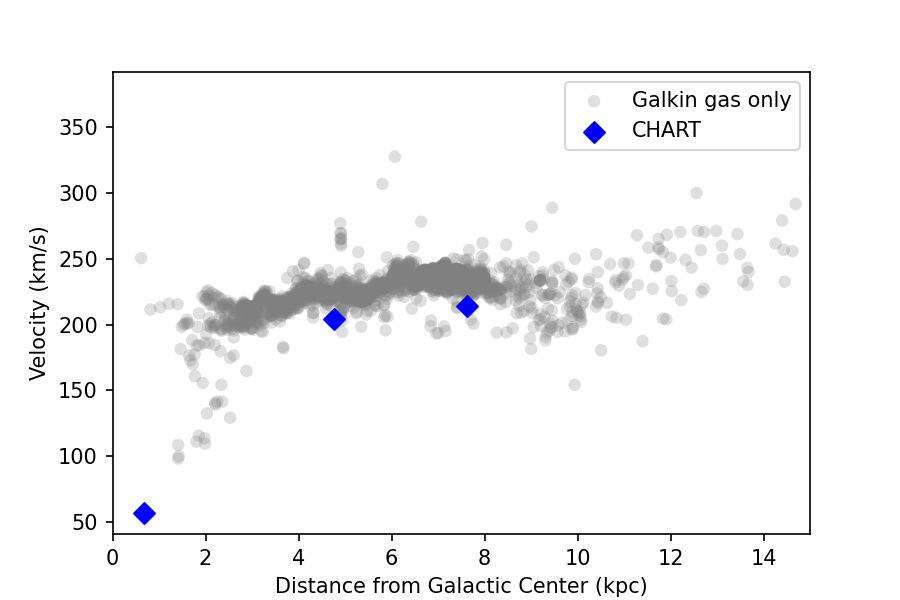

In [20]:
# Observed velocities -- change these for your data!
v_tps = np.array([4, 73, 38])  

vcfilename = 'test_data/vcdata_baseline_gas.dat'
posfilename = 'test_data/posdata_R75.dat'

vcfile = open(vcfilename,'r')
totallistvc=[]
i = 0
for line in vcfile:
    i += 1
    if (i > 2):
        values = np.array(line.split()[0:6]).astype(float)
        totallistvc.append(values)

posfile = open(posfilename,'r')
totallistpos=[]
i = 0
for line in posfile:
    i += 1
    if (i > 2):
        values = np.array(line.split()[0:7]).astype(float)
        totallistpos.append(values)

pos = [item[0] for item in totallistvc]
vel = [item[2] for item in totallistvc]


Vsun = 220 #estimated velocity of the sun
R0 = 8 #estimated distance of the sun to the center of the galaxy in kiloparsecs

#Calculates the tangent speed of the cloud with respect to the galactic center
V = v_tps + Vsun * np.sin(np.deg2rad(galactic_ls))
#Calculates the distance of the cloud from the center of the Milky Way
d = R0 * np.sin(np.deg2rad(galactic_ls))   

plt.figure(figsize=single_figsize)
plt.scatter(pos, vel, label='Galkin gas only', alpha=0.25, c='gray', edgecolor='none')
plt.scatter(d, V, label='CHART', c='blue',marker='D',s=50)
plt.legend()

plt.xlim(0.,15)
plt.xlabel('Distance from Galactic Center (kpc)')
plt.ylabel('Velocity (km/s)')
plt.show()

What do you notice here? How well does your rotation curve match?